  # Exploring Precipitation Patterns in UK Catchments







  ## Objectives



  By the end of this tutorial, you will:



  - Understand and calculate key precipitation indices



  - Visualize precipitation data using various techniques



  - Reinforce Python skills in data analysis and visualization.







  ## Prerequisites:



  - Basic Python understanding.



  - Familiarity with pandas and matplotlib.

  ## Dataset



  We will return to the CAMELS-GB dataset we used previously. Let's load data for one catchment:

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import TheilSenRegressor

# Use upper case for constants
DATADIR = os.path.join('data', '8344e4f3-d2ea-44f5-8afa-86d2987543a9', 'data')

# Load the data
id = '97002'
data = pd.read_csv(os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), parse_dates=[0])
data.head()



,date,precipitation,pet,temperature,discharge_spec,discharge_vol,peti,humidity,shortwave_rad,longwave_rad,windspeed
0,1970-10-01,9.93,1.02,8.91,NaN,NaN,1.31,6.01,61.76,325.33,7.65
1,1970-10-02,4.01,1.41,7.66,NaN,NaN,1.76,5.11,93.56,294.20,10.03
2,1970-10-03,7.27,1.17,8.77,NaN,NaN,1.40,5.41,61.95,321.14,5.41
3,1970-10-04,3.77,0.06,9.74,NaN,NaN,0.23,7.76,42.83,341.28,7.27
4,1970-10-05,1.19,1.56,9.46,NaN,NaN,1.86,5.49,92.13,299.08,7.90


  It's a good idea to check how many NaN values we have in the precipitation data:

In [18]:
# Check for missing values
print(data['precipitation'].isnull().sum())
# # Fill missing data or drop (depending on context)
# data.fillna(method='ffill', inplace=True)




0


  Let's start by plotting a scatter plot of the data:





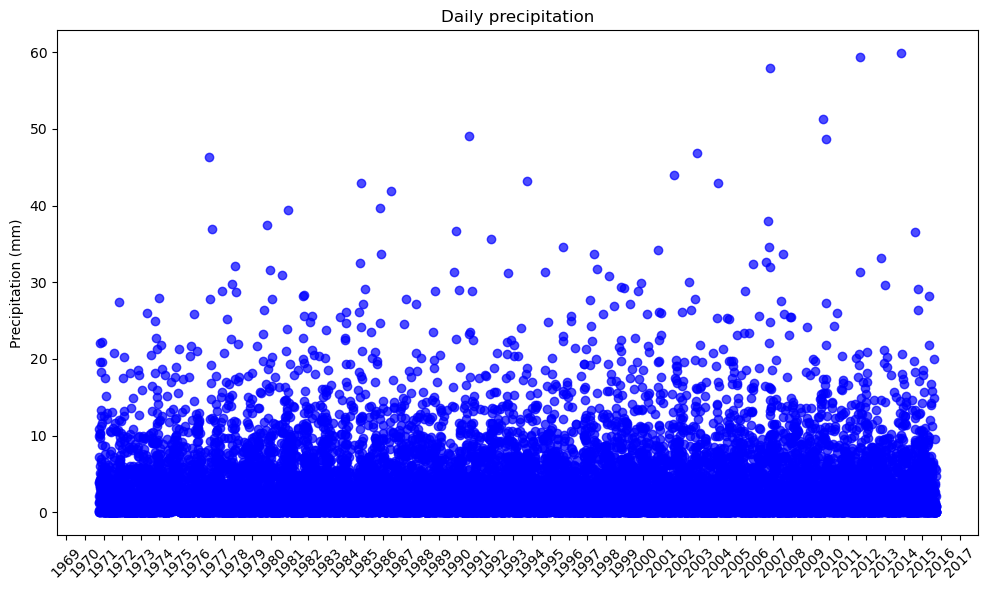

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(data['date'], data['precipitation'], color='b', alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title('Daily precipitation')
plt.ylabel('Precipitation (mm)')
plt.tight_layout()
plt.show()




  This is a lot of data to try to interpret. One thing that may interest us is the annual maximum daily precipitation. We can find this by grouping our dataframe by year, and retrieving the maximum value:

In [20]:
amax = data.groupby(data['date'].dt.year)[['precipitation']].max().reset_index()
amax.head()



,date,precipitation
0,1970,22.22
1,1971,27.41
2,1972,20.20
3,1973,27.97
4,1974,21.78


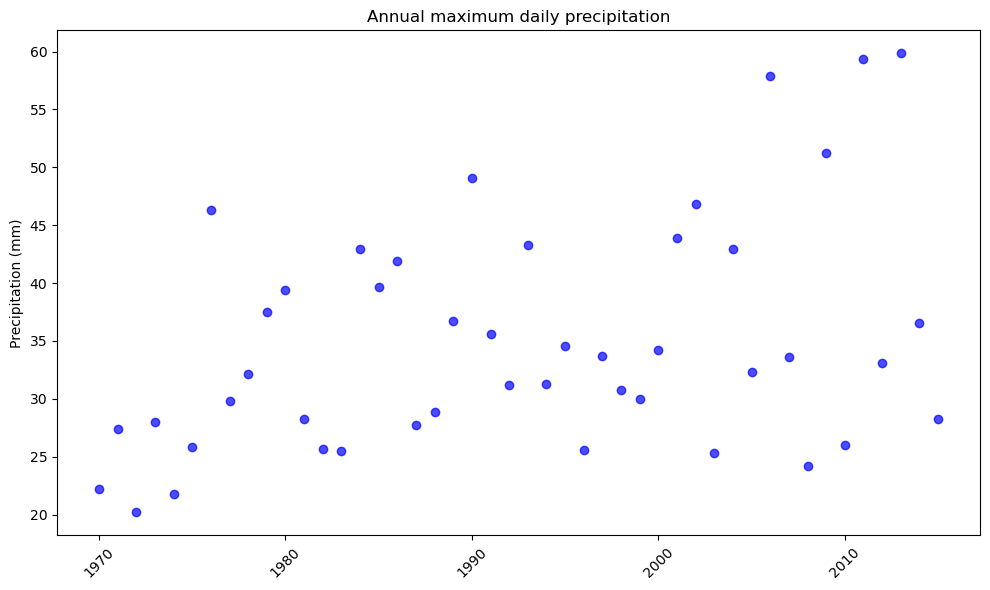

In [21]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(amax['date'], amax['precipitation'], color='b', alpha=0.7)
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title('Annual maximum daily precipitation')
plt.ylabel('Precipitation (mm)')
plt.tight_layout()
plt.show()



  It looks as though there might be a trend. How can we assess this quantitatively? One commonly used approach is to use the Theil-Sen estimator. This method provides a robust estimate of the trend slope and is less sensitive to outliers than some alternatives (e.g. linear regression).

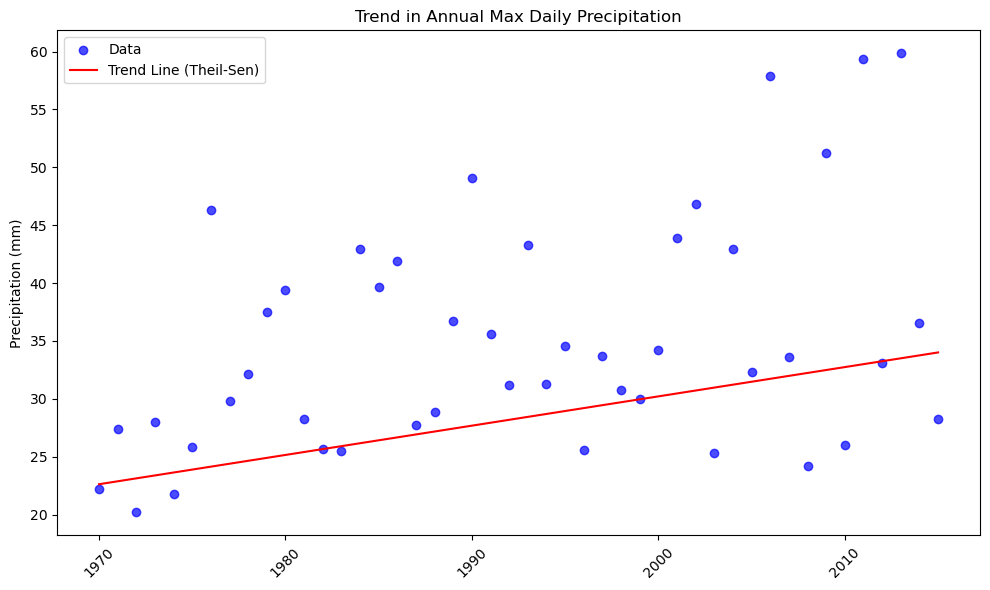

In [22]:
years = amax['date'].values.reshape(-1, 1)
precipitation = amax['precipitation'].values

model = TheilSenRegressor()
model.fit(years, precipitation)

trend_line = model.predict(years)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(amax['date'], amax['precipitation'], color='b', alpha=0.7, label='Data')
plt.plot(years, trend_line, color='red', label='Trend Line (Theil-Sen)')
plt.xticks(rotation=45)
plt.title('Trend in Annual Max Daily Precipitation')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.tight_layout()
plt.show()



  How can we summarise the trend, and compare it with other sites? We can extract the slope as follows:

In [23]:
slope = model.coef_[0]
print(f"Slope: {slope}")


Slope: 0.25294212741125943


 ## Taking it further

 Using the code above as a starting point, compute the slope of the trend for multiple basins.



 Have a look at Prosdocimi et al. ([NHESS](https://doi.org/10.5194/nhess-14-1125-2014), 2014) for inspiration.



 Think about the limitations of this analysis.

 - Where has the data come from?

 - Is a linear trend appropriate?

 - Is the annual maximum precipitation the best value to use? What else might be more appropriate for different applications?

 ## UK precipitation and the North Atlantic Oscillation

 In the lecture we spoke about the role of large-scale climate oscillations on precipitation patterns worldwide. In the UK, the North Atlantic Oscillation (NAO) exerts considerable influence on winter (December-February; DJF) precipitation.

 First of all we are going to download the NAO index from the internet. The following code downloads the data using Python's `reqeuests` library and converts the data to a Pandas dataframe:

In [24]:
import requests 
from io import StringIO

response = requests.get('https://crudata.uea.ac.uk/cru/data/nao/nao.dat')
data = response.text

# Convert string data into a StringIO object
data_io = StringIO(data)

# Read the data into a Pandas DataFrame
# Assuming the first value in each row is the index and the rest are data columns
nao_data = pd.read_csv(data_io, sep='\\s+', header=None)

# Set column names if needed
nao_data.columns = ['year'] + [f'{i}' for i in range(1, 13)] + ['annual_mean']
nao_data = nao_data.drop('annual_mean', axis=1)
nao_data = nao_data.melt(id_vars=['year'], var_name='month', value_name='nao')
nao_data.loc[nao_data['nao'] == -99.99, 'nao'] = np.nan

# Convert the Year/month columns to a date, and make this the index
nao_data['date'] = pd.to_datetime(nao_data['year'].astype(str) + '-' + nao_data['month'], format='%Y-%m')
nao_data = nao_data.set_index('date')

print(nao_data.head())


            year month   nao
date                        
1821-01-01  1821     1   NaN
1822-01-01  1822     1   NaN
1823-01-01  1823     1 -3.39
1824-01-01  1824     1 -0.16
1825-01-01  1825     1 -0.23


 The resulting dataframe contains monthly NAO values from 1821 to the present year, with missing values represented as NaN. Now we want to compute the DJF seasonal average, discarding other months. We can do this as follows:

In [25]:
# Increment the year in December by 1, so that season_year is the year of the end month (i.e. Feb)
nao_data['season_year'] = nao_data.index.year 
nao_data.loc[nao_data.index.month == 12, 'season_year'] += 1 

# Define a custom season assignment
season_mapping = {12: 'DJF', 1: 'DJF', 2: 'DJF'} 

# Add a 'season' column
nao_data['season'] = nao_data.index.month.map(season_mapping)

# Drop rows that don't belong to DJF:
nao_data = nao_data[nao_data['season'] == 'DJF']

# Finally, compute the seasonal averages:
nao_data = nao_data.groupby(['season_year', 'season'])[['nao']].mean().reset_index()
print(nao_data)


     season_year season       nao
0           1821    DJF       NaN
1           1822    DJF       NaN
2           1823    DJF -2.060000
3           1824    DJF -0.036667
4           1825    DJF -0.010000
..           ...    ...       ...
200         2021    DJF -0.616667
201         2022    DJF  1.723333
202         2023    DJF -0.183333
203         2024    DJF  0.775000
204         2025    DJF       NaN

[205 rows x 3 columns]


 Now we need to prepare our rainfall data. Lets create a function to compute the DJF mean precipitation for any given catchment, using the same aggregation method as we used for the NAO:

In [26]:
def compute_djf_precip(x): 

    x['date'] = pd.to_datetime(x['date'])
    x = x.set_index('date')
    x['season_year'] = x.index.year 
    x.loc[x.index.month == 12, 'season_year'] += 1

    # Define a custom season assignment
    season_mapping = {12: 'DJF', 1: 'DJF', 2: 'DJF'} 

    # Add a 'season' column
    x['season'] = x.index.month.map(season_mapping)

    # Drop rows that don't belong to a season
    x = x[x['season'] == 'DJF']

    # Compute seasonal averages
    x = x.groupby(['season_year', 'season'])[['precipitation']].mean().reset_index()
    return x


 We are interested in the relationship between preciptiation and NAO. Let's compute the correlation coefficient (R)

In [27]:
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm 

data = pd.read_csv(
    os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), 
    parse_dates=[0])

data = compute_djf_precip(data)
data = data.merge(nao_data, how='left', on=['season_year', 'season'])
pearson_corr = pearsonr(data['precipitation'], data['nao'])
result = pd.DataFrame.from_dict({'id': [f'{id}'], 'pearsonr': pearson_corr.statistic, 'pvalue': pearson_corr.pvalue})


 As in the previous notebook, let's load the catchment metadata (here we load the land use attributes - but it could be anything because we just want to get all the catchment IDs)

In [28]:
metadata_lu = pd.read_csv(os.path.join(DATADIR, f'CAMELS_GB_landcover_attributes.csv')) 
catchment_ids = metadata_lu['gauge_id'].to_list()
print(len(catchment_ids))


671


 OK, now we can loop through the catchments and compute the correlation of winter precipitation and the NAO index.

In [29]:
result_list = []
for id in catchment_ids:
    data = pd.read_csv(
        os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), 
        parse_dates=[0])

    data = compute_djf_precip(data)
    data = data.merge(nao_data, how='left', on=['season_year', 'season'])
    pearson_corr = pearsonr(data['precipitation'], data['nao'])
    result_list.append(pd.DataFrame.from_dict({'id': [f'{id}'], 'pearsonr': pearson_corr.statistic, 'pvalue': pearson_corr.pvalue}))

result = pd.concat(result_list).reset_index(drop=True)
print(result.head())

       id  pearsonr    pvalue
0   10002 -0.463538  0.001342
1   10003 -0.478366  0.000888
2    1001  0.380320  0.009963
3  101002 -0.014598  0.924174
4  101005 -0.022433  0.883710


 Now we should have a dataframe with columns `id`, `spearmanr` and `pvalue`. We're interested in (i) the strength of the relationship in various catchments, and (ii) how the spatial pattern varies in space. How might we visualize this information? One nice approach would be to create a choropleth map. You can do this by joining the dataset you have just created with the catchment polygons in the CAMELS-GB dataset - `data/8344e4f3-d2ea-44f5-8afa-86d2987543a9/data/CAMELS_GB_catchment_boundaries.shp`.

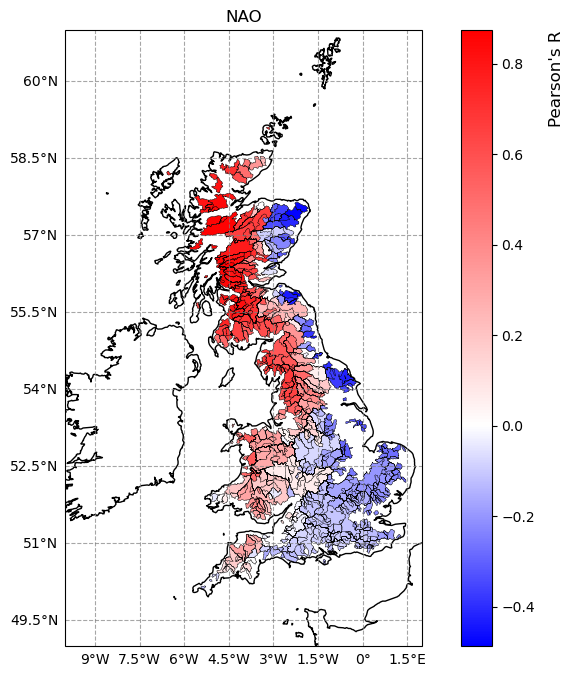

In [72]:
import geopandas as gpd
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Load shapefile with catchment boundaries
catchments = gpd.read_file("data/8344e4f3-d2ea-44f5-8afa-86d2987543a9/data/CAMELS_GB_catchment_boundaries.shp")
catchments = catchments.to_crs(4326)

# Merge the forest data with the catchments GeoDataFrame
catchments = catchments.merge(result, left_on = "ID_STRING", right_on = "id")
vmin, vmax = catchments['pearsonr'].min(), catchments['pearsonr'].max()

# Set up the plot with Cartopy for basemap
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the catchment-level choropleth (coloring by Pearson's R)
catchments.plot(
    column='pearsonr',  # Replace with your forest percent column
    cmap='bwr',
    legend=False,
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax
)

# Add catchment boundaries
catchments.boundary.plot(
    ax=ax,
    color='black',  # Boundary line color
    linewidth=0.25,    # Boundary line width
    linestyle='-',  # Boundary line style
    zorder=2,       # Make sure the boundaries are on top of the fill
    transform=ccrs.PlateCarree()
) 

# Add coastlines for context
ax.coastlines()

# Add a title
ax.set_title("NAO")

# Set extent
ax.set_extent([-10, 2, 49, 61], crs=ccrs.PlateCarree())  # [west, east, south, north]

# Make pretty axes
gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.7)
gl.top_labels = False  # Disable top labels
gl.right_labels = False  # Disable right labels

# Create a custom colorbar
sm = plt.cm.ScalarMappable(cmap="bwr", norm=mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax))
sm.set_array([])  # Dummy array for the colorbar
cbar = plt.colorbar(sm, ax=ax, orientation="vertical")
cbar.ax.set_yscale('linear')
cbar.set_label("Pearson's R", fontsize=12, labelpad=10, loc="top")

# Show the plot
plt.show()